In [2]:
import sys
sys.path.append('../')

In [3]:
from torchdyn.models import *
from torchdyn import *
from torchdyn.datasets import *

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [4]:
d = ToyDataset()
X, yn = d.generate(n_samples=128, dataset_type='moons', noise=.4)

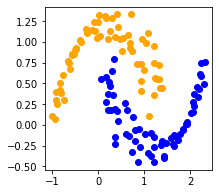

In [5]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [6]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [25]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module): #settings:dict={}):
        super().__init__()
        #defaults.update(settings)
        #self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)  
        loss = nn.CrossEntropyLoss()(y_hat, y)
        print(loss)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

In [26]:
from torch.autograd import grad as grad

In [87]:
import pdb
class intloss(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, x):
        #x.requires_grad_(True)
        loss = 1e-4*torch.abs(self.f(x)).sum(1) #grad(self.f(s, x), x, create_graph=True
        return loss

In [88]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(6, 64),
        nn.Tanh(), 
        nn.Linear(64, 2))

# neural ODE
model = NeuralDE(f, 
                 order=3,
                 solver='dopri5', 
                 sensitivity='adjoint', 
                 controlled=False,
                 intloss=None).to(device)
seq = nn.Sequential(Augmenter(1, 4), model)

In [89]:
torch.rand(10).requires_grad_(True).shape

torch.Size([10])

In [90]:
# train the neural ODE
learn = Learner(seq)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

GPU available: True, used: False
No environment variable for node rank defined. Set as 0.

  | Name               | Type       | Params
----------------------------------------------
0 | model              | Sequential | 578   
1 | model.0            | Augmenter  | 0     
2 | model.1            | NeuralDE   | 578   
3 | model.1.defunc     | DEFunc     | 578   
4 | model.1.defunc.m   | Sequential | 578   
5 | model.1.defunc.m.0 | Linear     | 448   
6 | model.1.defunc.m.1 | Tanh       | 0     
7 | model.1.defunc.m.2 | Linear     | 130   
8 | model.1.adjoint    | Adjoint    | 0     


tensor(2.3739, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3089, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2499, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1964, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1478, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.1034, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0627, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0252, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9905, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9582, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9281, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8998, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8733, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8483, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8247, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8022, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7808, device='cuda:0', grad_fn=<NllLossBackward

Detected KeyboardInterrupt, attempting graceful shutdown...


tensor(1.6304, device='cuda:0', grad_fn=<NllLossBackward>)



1

**Plots**

In [167]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
X_d = seq[0](X_train)
trajectory = model.trajectory(X_d, s_span).detach().cpu()

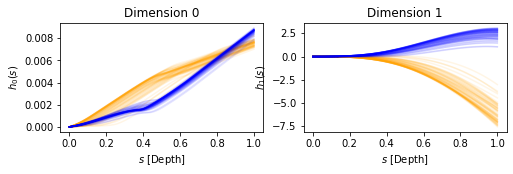

In [168]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

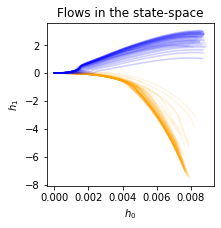

In [169]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X),)

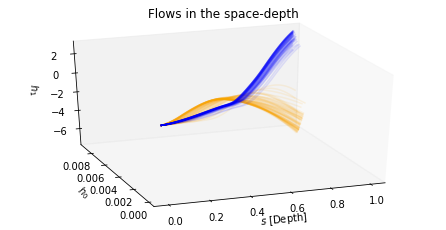

In [170]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))